In [1]:
import os
import sys
import inspect
from importlib import reload
from tqdm import tqdm
from pathlib import Path

import numpy as np
import numexpr as ne
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.constants import pi, c, epsilon_0, mu_0

rcParams['figure.figsize'] = (8,6)
rcParams['font.size'] = 20

import quvac
from quvac.field.paraxial_gaussian import ParaxialGaussianAnalytic
from quvac.field.external_field import ExternalField
from quvac.field.maxwell import ParaxialGaussianMaxwell
from quvac.field.utils import get_field_energy, get_field_energy_kspace
from quvac.integrator.vacuum_emission import VacuumEmission
from quvac.analytic_scalings import get_two_paraxial_scaling
from quvac.grid import GridXYZ
from quvac.grid_utils import get_xyz_size, get_t_size, setup_grids
from quvac.utils import write_yaml, read_yaml
from quvac.simulation import quvac_simulation
reload(quvac.simulation)
reload(quvac.field.maxwell)
reload(quvac.field.abc)

<module 'quvac.field.abc' from '/home/maximus/Research/github/quantum-vacuum/src/quvac/field/abc.py'>

## Launch a single simulation

In [26]:
# Define field parameters
tau = 25e-15
W = 25
lam = 0.8e-6
w0 = 2*lam
theta = 180
beta = 0

# Define fields
field_1 = {
    "field_type": "paraxial_gaussian_maxwell",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

field_2 = {
    "field_type": "paraxial_gaussian_maxwell",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

# fields_params = [field_1, field_2]
fields_params = [field_1]

# x0, y0, z0 = 5*c*tau, 15*w0, 5*c*tau
x0, y0, z0 = 15*w0, 15*w0, 6*c*tau
print(x0, y0, z0)
box_size = np.array([x0, y0, z0])/2
Nxyz = get_xyz_size(fields_params, box_size)
Nx, Ny, Nz = [1*N for N in Nxyz]
print(Nx, Ny, Nz)

t0 = 4*tau
Nt = get_t_size(-t0/2, t0/2, lam)

ini_data = {
    'fields': fields_params,
    'grid': {
        'mode': 'direct',
        'box_xyz': [x0,y0,z0],
        'Nxyz': [Nx,Ny,Nz],
        'box_t': t0,
        'Nt': Nt
    },
    'performance': {
        'nthreads': 8
    }
}

path = '../data/test_maxwell_one_field'
Path(path).mkdir(parents=True, exist_ok=True)

ini_file = os.path.join(path, 'ini.yaml')
write_yaml(ini_file, ini_data)

# quvac_simulation(ini_file)
SCRIPT_PATH = '../src/quvac/simulation.py'

2.4e-05 2.4e-05 4.49688687e-05
30 30 192


In [27]:
status = os.system(f"{SCRIPT_PATH} --input {ini_file}")

24.841191297439686

Timings:
Field setup:                        0.39 s
Vacem setup:                        0.01 s
Amplitudes calculation:             7.01 s
Postprocess:                        0.03 s
-------------------------------------------------
Per iteration:                      0.03 s  
-------------------------------------------------
Total:                              7.44 s

Memory (max usage):
Amplitudes calculation:          246.98 MB
Total:                           246.98 MB

Simulation finished!


In [28]:
data_file = os.path.join(path, 'spectra.npz')
data = np.load(data_file)
print(list(data.keys()))

['kx', 'ky', 'kz', 'N_xyz', 'N_tot', 'ep', 'Np_xyz', 'Np_tot']


In [29]:
N_signal_num = data['N_tot']
print(N_signal_num)

0.014462965316088783


In [10]:
N_signal_th, N_perp_th = get_two_paraxial_scaling(fields_params)
N_signal_th

28.380257254278188

In [17]:
N_signal_th / N_signal_num

2.228730013326032

### Test how a1, a2 look like

In [30]:
ini_config = read_yaml(ini_file)
fields_params = ini_config["fields"]
grid_params = ini_config["grid"]
perf_params = ini_config["performance"]
nthreads = perf_params['nthreads']

grid_xyz, grid_t = setup_grids(fields_params, grid_params)
field = ExternalField(fields_params, grid_xyz, nthreads=nthreads)


24.841191297439686


In [31]:
maxwell_f = field.fields[0]
kabs = maxwell_f.kabs
a1 = maxwell_f.a1 / (1j*kabs)
a1[0,0,0] = 0.
a2 = maxwell_f.a2 / (1j*kabs)
a2[0,0,0] = 0.

a1 = np.fft.fftshift(a1)
a2 = np.fft.fftshift(a2)

/tmp/ipykernel_69428/345932670.py:3: RuntimeWarning: divide by zero encountered in divide
  a1 = maxwell_f.a1 / (1j*kabs)
/tmp/ipykernel_69428/345932670.py:5: RuntimeWarning: invalid value encountered in divide
  a2 = maxwell_f.a2 / (1j*kabs)


In [32]:
kx = np.fft.fftshift(maxwell_f.kx.flatten())
ky = np.fft.fftshift(maxwell_f.ky.flatten())
kz = np.fft.fftshift(maxwell_f.kz.flatten())
kabs = np.fft.fftshift(maxwell_f.kabs)
# kx /= kabs
# ky /= kabs
# kz /= kabs
nx, ny, nz = len(kx), len(ky), len(kz)

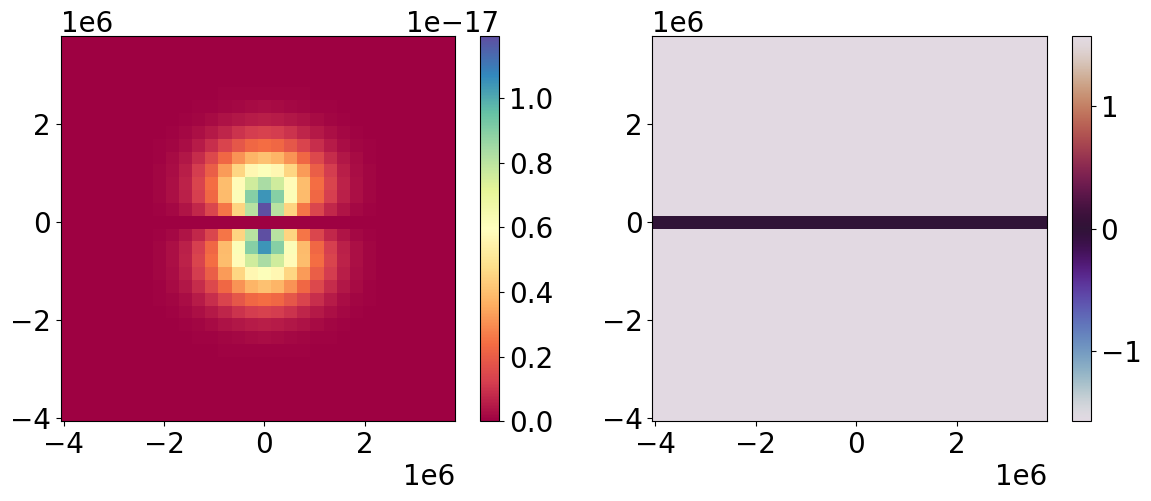

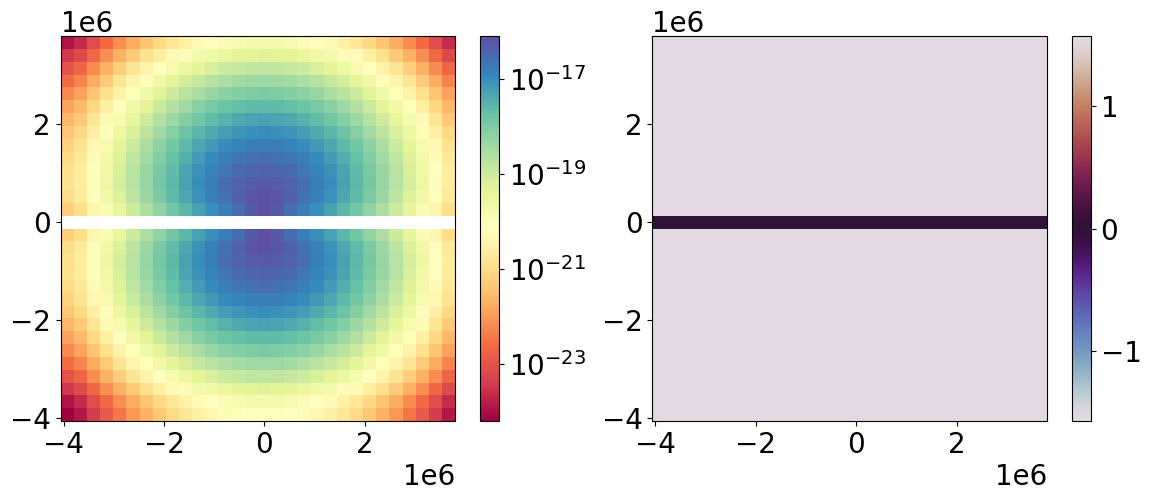

In [35]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(kx, ky, np.abs(a2[:,:,40]).T, cmap='Spectral')
# plt.pcolormesh(kx, ky, np.abs(a2[:,:,nz//2]).T,
#                norm=matplotlib.colors.LogNorm())
plt.colorbar()

plt.subplot(1,2,2)
# plt.pcolormesh(kx, ky, np.angle(a2[:,:,nz//2]).T, cmap='inferno')
plt.pcolormesh(kx, ky, np.angle(a2[:,:,40]).T, cmap='twilight')
# plt.pcolormesh(kx, ky, np.abs(a2[:,:,nz//2]).T,
#                norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(kx, ky, np.abs(np.sum(a2,axis=2)).T, cmap='Spectral',
               norm=matplotlib.colors.LogNorm())
# plt.pcolormesh(kx, ky, np.abs(a2[:,:,nz//2]).T,
#                norm=matplotlib.colors.LogNorm())
plt.colorbar()

plt.subplot(1,2,2)
# plt.pcolormesh(kx, ky, np.angle(a2[:,:,nz//2]).T, cmap='inferno')
plt.pcolormesh(kx, ky, np.angle(np.sum(a2,axis=2)).T, cmap='twilight')
# plt.pcolormesh(kx, ky, np.abs(a2[:,:,nz//2]).T,
#                norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

<class 'quvac.field.maxwell.ParaxialGaussianMaxwell'>


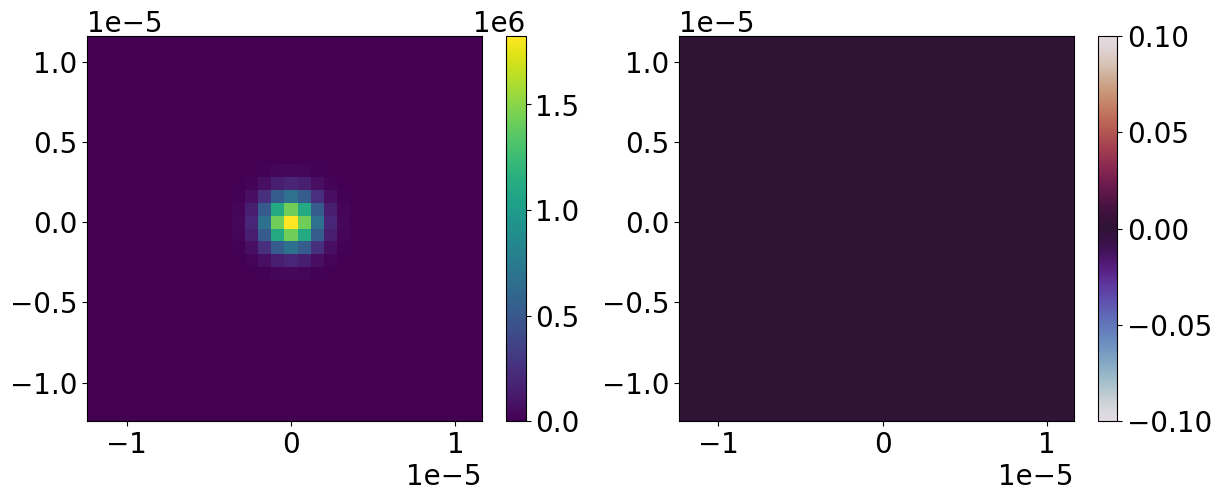

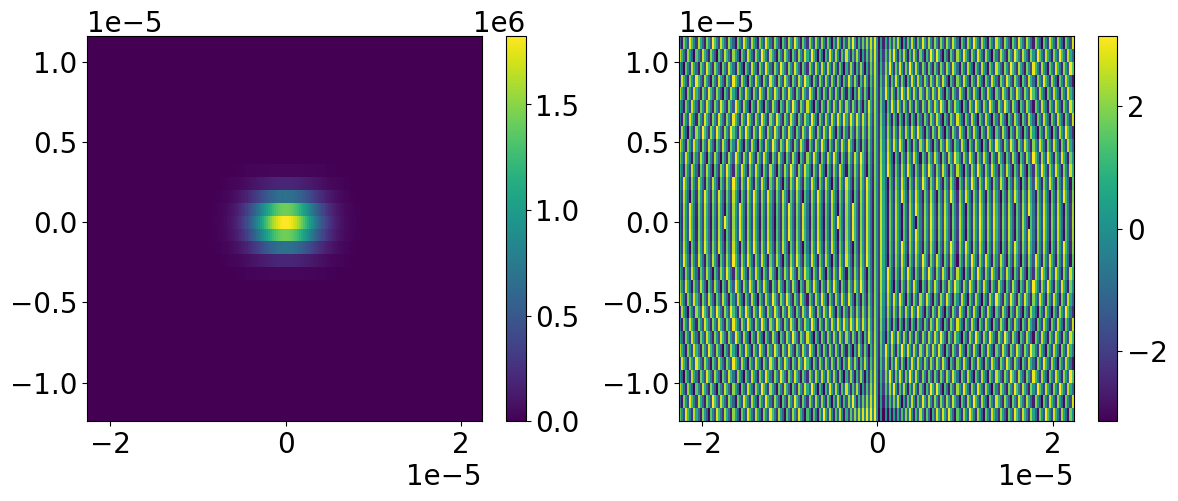

In [10]:
E_ini = field.fields[0].E_ini
print(type(field.fields[0]))
x,y,z = field.grid.grid

# for i in range(3):
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(y, x, np.abs(E_ini[0][:,:,nz//2]))
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(y, x, np.angle(E_ini[0][:,:,nz//2]), cmap='twilight')
plt.colorbar()
plt.show()

# ==================================================
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(z, x, np.abs(E_ini[0][:,ny//2,:]))
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(z, x, np.angle(E_ini[0][:,ny//2,:]))
plt.colorbar()
plt.show()

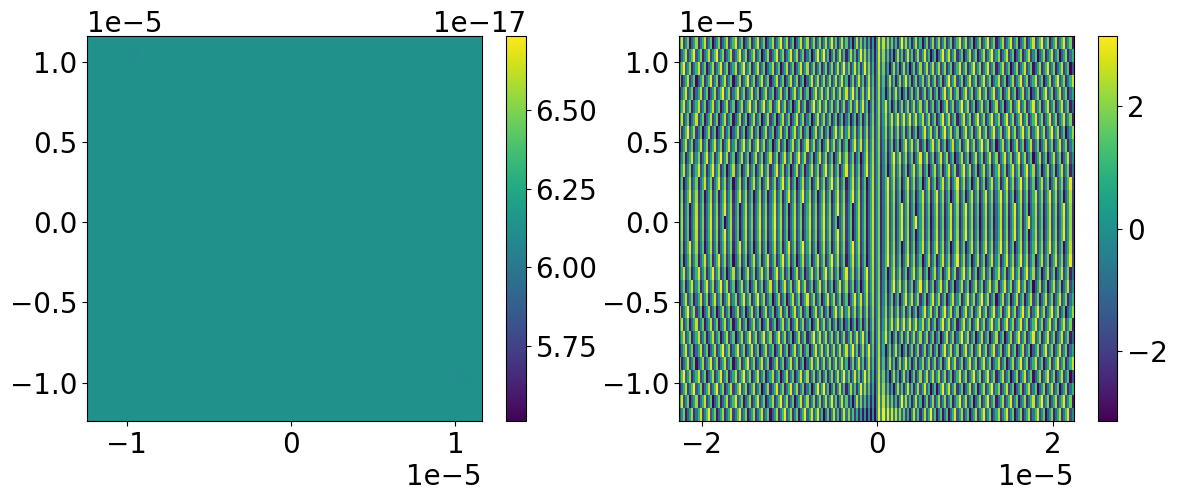

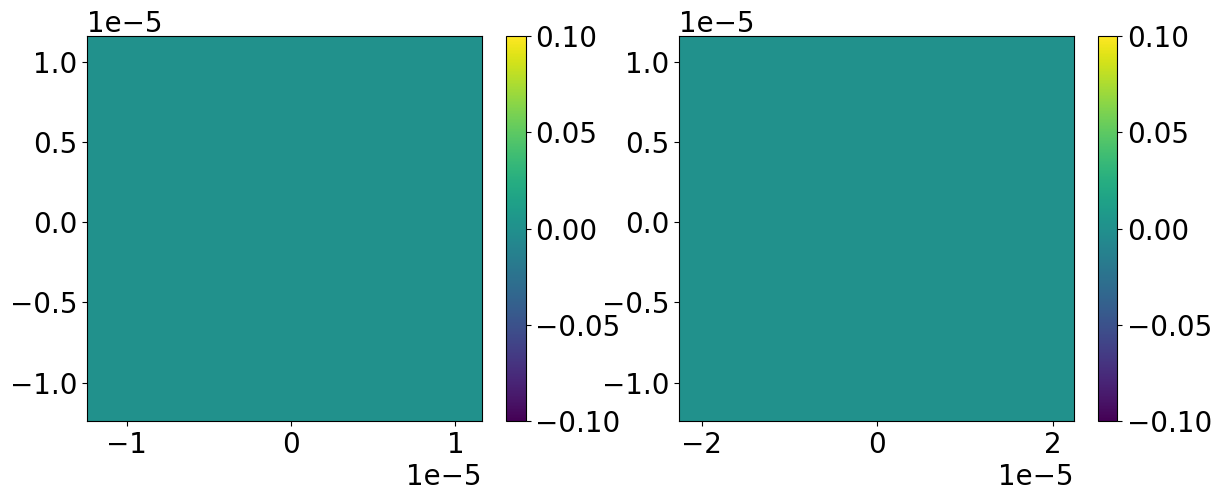

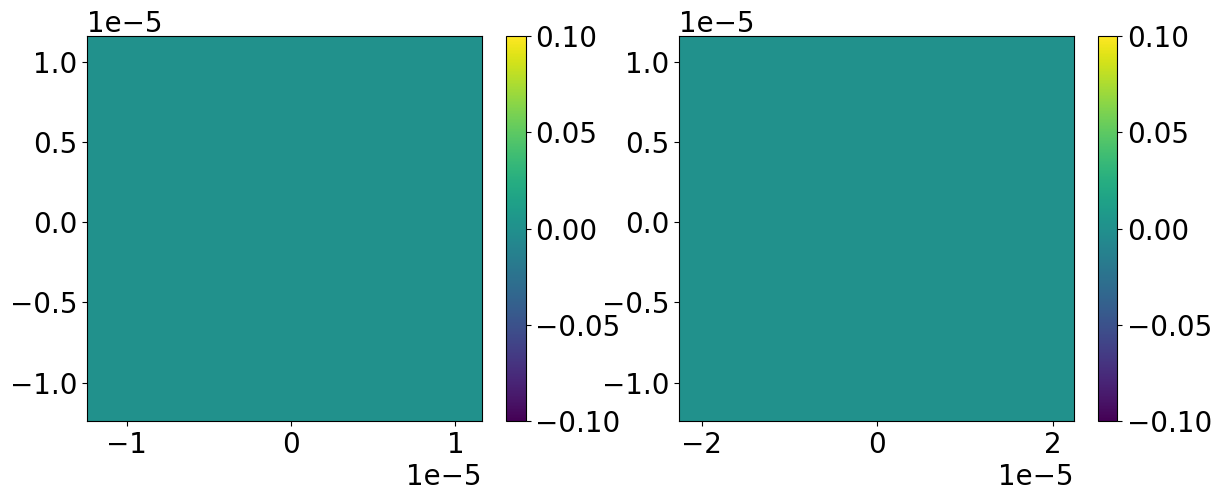

In [11]:
for i in range(3):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.pcolormesh(y, x, np.angle(E_ini[i][:,:,nz//2]))
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.pcolormesh(z, x, np.angle(E_ini[i][:,ny//2,:]))
    plt.colorbar()
    plt.show()

### Test how ini field looks like

## Test: two paraxial gaussians for different collision angles

In [16]:
tau = 15e-15
W = 25
lam = 0.8e-6
w0 = 4*lam
theta = 145
beta = 90

field_1 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

field_2 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

fields_params = [field_1, field_2]

x0, y0, z0 = 5*c*tau, 15*w0, 5*c*tau
L = np.array([x0, y0, z0])
Nxyz = get_xyz_size(fields_params, L/2)
print(Nxyz)
Nx, Ny, Nz = Nxyz
x = np.linspace(-x0/2,x0/2,2*Nx)
y = np.linspace(-y0/2,y0/2,2*Ny)
z = np.linspace(-z0/2,z0/2,2*Nz)
grid = GridXYZ((x, y, z))

t0 = 2*tau
Nt = get_t_size(-t0, t0, lam)
print(Nt)
t_grid = np.linspace(-t0, t0, Nt)

[72, 30, 104]
135


### Single simulation

In [17]:
N_signal, N_perp = get_two_paraxial_scaling(fields_params)
print(f'Signal (theory): {N_signal:.3f}')

Signal (theory): 4.284


In [18]:
field = ExternalField(fields_params, grid)
vacem = VacuumEmission(field, grid)
vacem.calculate_amplitudes(t_grid)
N_signal_num = vacem.calculate_total_signal()
print(f'Signal (num)   : {N_signal_num:.3f}')

Signal (num)   : 3.232


### Different collision angles

In [4]:
thetas = np.linspace(10,180,18)
Ntots = np.zeros_like(thetas)
Nths = np.zeros_like(thetas)

In [7]:
for i,theta in enumerate(tqdm(thetas)):
    field_2['theta'] = float(theta)
    fields_params = [field_1, field_2]

    x0, y0, z0 = 4*c*tau, 12*w0, 4*c*tau
    L = np.array([x0, y0, z0])
    Nxyz = get_xyz_size(fields_params, L/2)
    print(Nxyz)
    Nx, Ny, Nz = Nxyz
    x = np.linspace(-x0/2,x0/2,Nx)
    y = np.linspace(-y0/2,y0/2,Ny)
    z = np.linspace(-z0/2,z0/2,Nz)
    grid = GridXYZ((x, y, z))
    
    field = ExternalField(fields_params, grid)
    vacem = VacuumEmission(field, grid)
    vacem.calculate_amplitudes(t_grid)
    Ntot = vacem.calculate_total_signal()
    Ntots[i] = Ntot

    N_signal, N_perp = get_two_paraxial_scaling(fields_params)
    Nths[i] = N_signal

  0%|                                                         | 0/18 [00:00<?, ?it/s]

[25, 24, 84]


  6%|██▋                                              | 1/18 [00:02<00:38,  2.29s/it]

[39, 24, 84]


 11%|█████▍                                           | 2/18 [00:05<00:45,  2.85s/it]

[52, 24, 84]


 17%|████████▏                                        | 3/18 [00:09<00:51,  3.42s/it]

[63, 24, 84]


 22%|██████████▉                                      | 4/18 [00:15<01:02,  4.43s/it]

[72, 24, 84]


 28%|█████████████▌                                   | 5/18 [00:21<01:06,  5.12s/it]

[78, 24, 84]


 33%|████████████████▎                                | 6/18 [00:28<01:09,  5.76s/it]

[84, 24, 84]


 39%|███████████████████                              | 7/18 [00:35<01:07,  6.15s/it]

[84, 24, 84]


 44%|█████████████████████▊                           | 8/18 [00:42<01:04,  6.40s/it]

[84, 24, 84]


 50%|████████████████████████▌                        | 9/18 [00:49<00:59,  6.61s/it]

[84, 24, 84]


 56%|██████████████████████████▋                     | 10/18 [00:56<00:53,  6.72s/it]

[84, 24, 84]


 61%|█████████████████████████████▎                  | 11/18 [01:03<00:47,  6.80s/it]

[78, 24, 84]


 67%|████████████████████████████████                | 12/18 [01:10<00:40,  6.83s/it]

[72, 24, 84]


 72%|██████████████████████████████████▋             | 13/18 [01:16<00:32,  6.59s/it]

[63, 24, 84]


 78%|█████████████████████████████████████▎          | 14/18 [01:22<00:25,  6.34s/it]

[52, 24, 84]


 83%|████████████████████████████████████████        | 15/18 [01:26<00:17,  5.71s/it]

[39, 24, 84]


 89%|██████████████████████████████████████████▋     | 16/18 [01:30<00:09,  4.95s/it]

[25, 24, 84]


 94%|█████████████████████████████████████████████▎  | 17/18 [01:32<00:04,  4.09s/it]

[np.int64(11), 24, 84]


100%|████████████████████████████████████████████████| 18/18 [01:33<00:00,  5.19s/it]


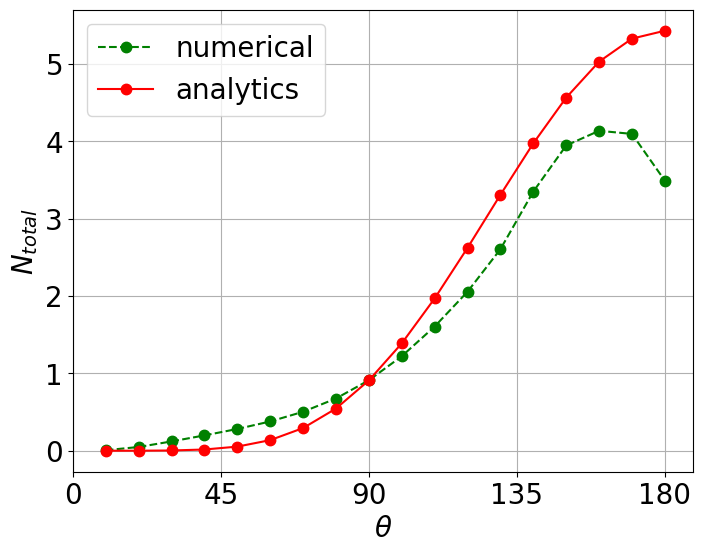

In [8]:
# This is for comparison with Fig.6 from H. Gies, et al "All-optical signatures of 
# strong-field QED in the vacuum emission picture." Physical Review D 97.3 (2018): 036022.

plt.figure(figsize=(8,6))
plt.plot(thetas, Ntots, '.--', color='green', ms=15, label='numerical')
plt.plot(thetas, Nths, '.-', color='red', ms=15, label='analytics')
# plt.yscale('log')
plt.grid()
plt.xlabel('$\\theta$')
plt.ylabel('$N_{total}$')
plt.xticks([45*i for i in range(5)])
# plt.yticks([50*i for i in range(7)])
plt.legend(loc='best')

plt.savefig(f'../imgs/tests/2_paraxial_Ntot_theta_{theta}_beta_{beta}.png',
            bbox_inches='tight')
plt.show()

### Compare with Alex simulations

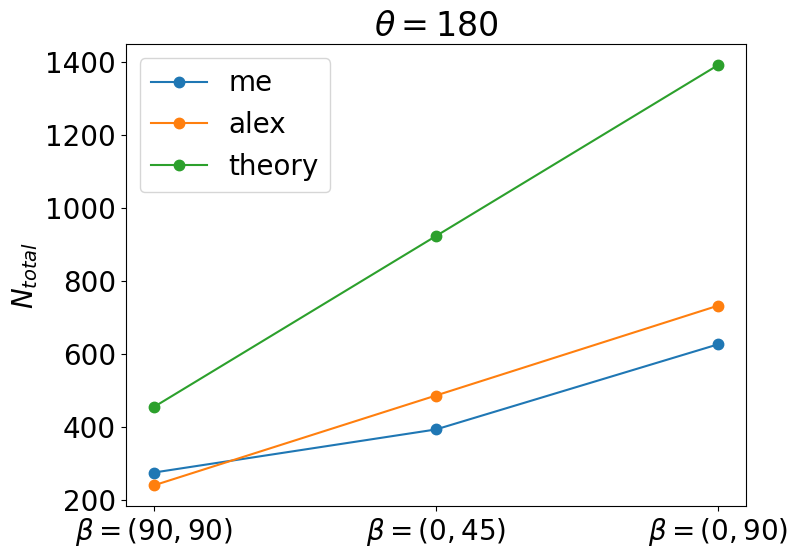

In [57]:
my_data = [274, 392, 625]
alex_data = [239, 485, 731]
theory_data = [454, 922, 1390]

plt.figure()
plt.plot(my_data, '.-', ms=15, label='me')
plt.plot(alex_data, '.-', ms=15, label='alex')
plt.plot(theory_data, '.-', ms=15, label='theory')
plt.xticks([0,1,2], labels=['$\\beta=(90,90)$', '$\\beta=(0,45)$', '$\\beta=(0,90)$'])
plt.ylabel("$N_{total}$")
plt.title('$\\theta = 180$')
plt.legend()
plt.show()

## Test Euler rotation

In [27]:
from scipy.spatial.transform import Rotation
phi = 67*np.pi/180
theta = 145*np.pi/180
beta = 45*np.pi/180
k = np.array([np.cos(phi)*np.sin(theta),
              np.sin(phi)*np.sin(theta),
              np.cos(theta)])
print(f'k      : {k}')
e1 = np.array([np.cos(phi)*np.cos(theta),
               np.sin(phi)*np.cos(theta),
               -np.sin(theta)])
e2 = np.array([-np.sin(phi),
               np.cos(phi),
               0.])
eb = e1 * np.cos(beta) + e2 * np.sin(beta)

rotation = Rotation.from_euler('ZYZ', (phi,theta,beta))
rotation_bwd = rotation.inv()

k_rotated = rotation_bwd.apply(k)
print(f'k(rot) : {k_rotated}')

eb_rotated = rotation_bwd.apply(eb)
print(f'eb     : {eb}')
print(f'eb(rot): {eb_rotated}')

eb_ = rotation.apply(eb_rotated)
print(f'eb...  : {eb_}')

k      : [ 0.22411417  0.52797989 -0.81915204]
k(rot) : [-2.77555756e-17 -5.55111512e-17  1.00000000e+00]
eb     : [-0.87721762 -0.25689352 -0.40557979]
eb(rot): [ 1.00000000e+00 -8.32667268e-17  0.00000000e+00]
eb...  : [-0.87721762 -0.25689352 -0.40557979]


## Random tests

In [19]:
from astropy.coordinates import cartesian_to_spherical

xyz = x,y,z = [np.linspace(-1,1,100)[:,None,None],
               np.linspace(-1,1,100)[None,:,None],
               np.linspace(-1,1,100)[None,None,:]]
sph = r,theta,phi = cartesian_to_spherical(*xyz)
sph = r,theta,phi = [np.array(coord) for coord in sph]
theta += np.pi/2
print(r.min(), r.max())
print('='*20)
print(theta.min(), theta.max())
print('='*20)
print(phi.min(), phi.max())
print('='*20)

0.017495462702715854 1.7320508075688772
0.014284013928896666 3.1273086396608964
0.010100666585321971 6.273084640594265


## Check maxwell class

In [2]:
# Define field parameters
tau = 25e-15
W = 25
lam = 0.8e-6
w0 = 2*lam
theta = 90
beta = 90

# Define fields
field_1 = {
    "field_type": "paraxial_gaussian_maxwell",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

fields_params = [field_1]

x0, y0, z0 = 5*c*tau, 12*w0, 5*c*tau
box_size = np.array([x0, y0, z0])
Nxyz = get_xyz_size(fields_params, box_size/2)
Nx, Ny, Nz = Nxyz
x = np.linspace(-x0/2,x0/2,Nx)
y = np.linspace(-y0/2,y0/2,Ny)
z = np.linspace(-z0/2,z0/2,Nz)
grid = GridXYZ((x, y, z))

t0 = 2*tau
Nt = get_t_size(-t0, t0, lam)
t_grid = np.linspace(-t0, t0, Nt)

In [3]:
field = ParaxialGaussianMaxwell(field_1, grid)

In [4]:
E, B = field.calculate_field(t=10e-15)

In [5]:
get_field_energy(E, B, field.dV)

np.float64(24.999999999999915)

In [6]:
W = get_field_energy_kspace(field.a1, field.a2, field.kabs, field.dVk)
W

np.float64(25.00000000000037)

## Check how various DFTs work

In [85]:
import numpy as np
import pyfftw
from scipy.constants import pi

def gauss(x, a=1.):
    return np.exp(-a*x**2)

def gauss_f(kx, a=1.):
    return np.sqrt(pi/a) * np.exp(-kx**2/(4*a))

def cft_numpy(arr, x, fft_module='numpy'):
    fft_module = np.fft if fft_module == 'numpy' else pyfftw.interfaces.numpy_fft
    dx = x[1] - x[0]
    kx = 2*pi*np.fft.fftfreq(len(x), dx)
    arr_k = fft_module.fft(arr)
    arr_k_shifted = dx * np.exp(-1j*kx*x[0]) * arr_k
    return arr_k_shifted, kx

def icft_numpy(arr_k, kx, fft_module='numpy'):
    fft_module = np.fft if fft_module == 'numpy' else pyfftw.interfaces.numpy_fft
    dkx = kx[1] - kx[0]
    x = np.fft.fftfreq(len(kx), dkx/(2*pi))
    arr = fft_module.ifft(arr_k, norm='forward')
    k0 = np.fft.fftshift(kx)[0]
    arr_shifted = dkx/(2*pi) * np.exp(1j*k0*x) * arr
    return arr_shifted, x

# Write analogs with pyfftw
def cft_pyfftw(arr, x):
    dx = x[1] - x[0]
    kx = 2*pi*np.fft.fftfreq(len(x), dx)

    arr = arr.astype(np.complex128)
    arr_k = np.zeros(arr.shape, dtype=np.complex128)
    pyfftw_scheme = pyfftw.FFTW(arr, arr_k, axes=(0,),
                                direction='FFTW_FORWARD',
                                flags=('FFTW_MEASURE', ),
                                threads=1)
    pyfftw_scheme.execute()
    
    arr_k_shifted = dx * np.exp(-1j*kx*x[0]) * arr_k
    return arr_k_shifted, kx

def icft_pyfftw(arr_k, kx):
    dkx = kx[1] - kx[0]
    x = np.fft.fftfreq(len(kx), dkx/(2*pi))
    
    arr_k = arr_k.astype(np.complex128)
    arr = np.zeros_like(arr_k)
    pyfftw_scheme = pyfftw.FFTW(arr_k, arr, axes=(0,),
                                direction='FFTW_BACKWARD',
                                flags=('FFTW_MEASURE', ),
                                threads=1)
    pyfftw_scheme.execute()
    
    k0 = np.fft.fftshift(kx)[0]
    arr_shifted = dkx/(2*pi) * np.exp(1j*k0*x) * arr
    return arr_shifted, x

[-10.   -9.8  -9.6  -9.4  -9.2]
[-10.   -9.8  -9.6  -9.4  -9.2]
False


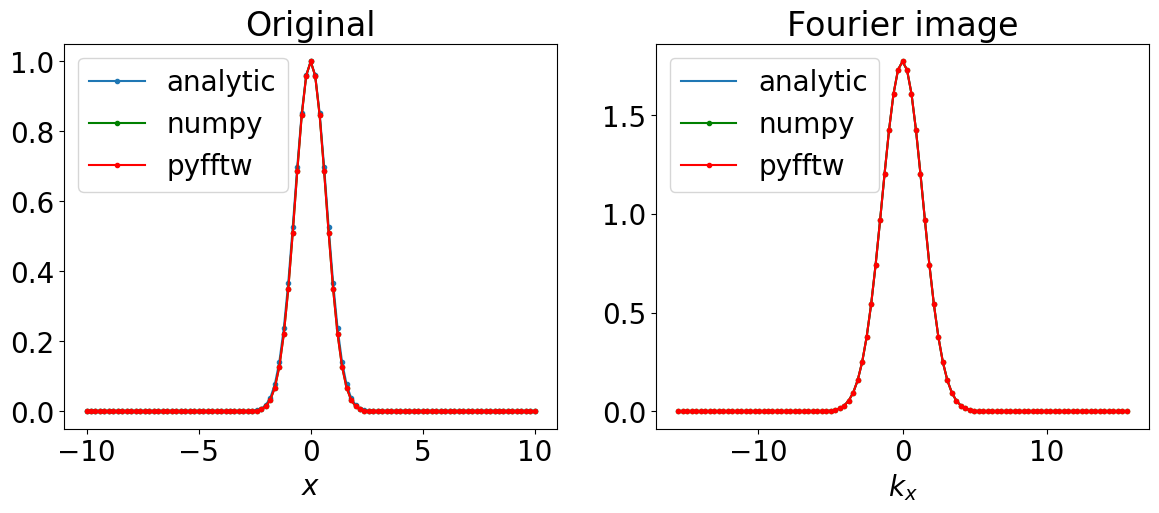

In [105]:
x0 = 10
dx = 0.2
Nx = int(2*x0/dx + 1)
x = np.linspace(-x0, x0, Nx)
kx = np.fft.fftshift(2*pi*np.fft.fftfreq(Nx, dx))

a = 1.
f = gauss(x, a)
# Analytic CFT
fk = gauss_f(kx, a)

# Numeric
module = 'numpy'
fk_np, kx_fft = cft_numpy(f, x, fft_module=module)
f_np, x_fft = icft_numpy(fk_np, kx, fft_module=module)
print(x[:5])
print(np.fft.fftshift(x_fft)[:5])

fk_pyfftw, kx_fft = cft_pyfftw(f, x)
f_pyfftw, x_fft = icft_pyfftw(fk_pyfftw, kx)

print(np.allclose(f, np.fft.fftshift(f_np), rtol=1e-1))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(x, f, '.-', label='analytic')
plt.plot(x, np.fft.fftshift(f_np), '.-', color='green', label='numpy')
plt.plot(x, np.fft.fftshift(f_pyfftw), '.-', color='red', label='pyfftw')
plt.xlabel('$x$')
plt.title('Original')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(kx, fk, label='analytic')
plt.plot(kx, np.fft.fftshift(fk_np), '.-', color='green', label='numpy')
plt.plot(kx, np.fft.fftshift(fk_pyfftw), '.-', color='red', label='pyfftw')
plt.xlabel('$k_x$')
plt.title('Fourier image')
plt.legend(loc='upper left')
plt.show()

In [107]:
np.sum(np.isclose(f, 0.))

58

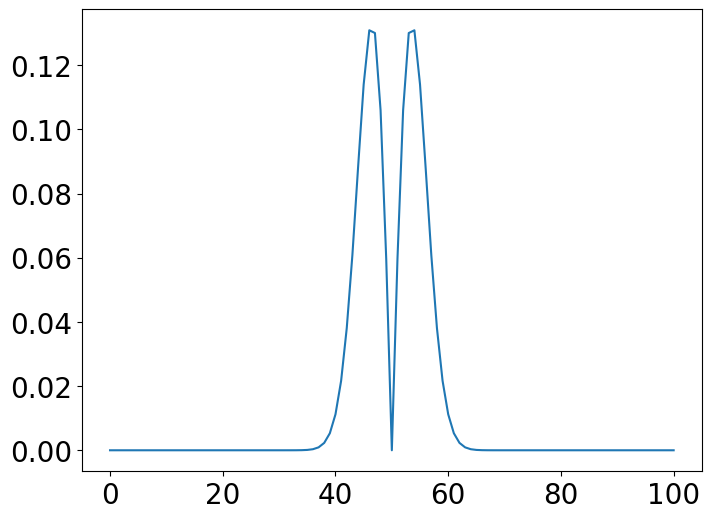

In [108]:
plt.plot(np.abs(f - np.fft.fftshift(f_np)))